In [11]:
from python_speech_features import mfcc # Mel Frequency Cepstral Co-efficients
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import librosa, IPython
import librosa.display as lplt

import os
import pickle
import random
import operator

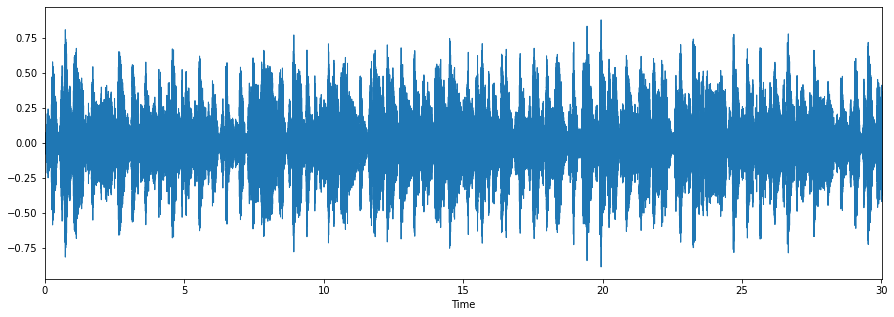

In [12]:
audio_fp = 'Dataset/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

# plot sample file
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:1641: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


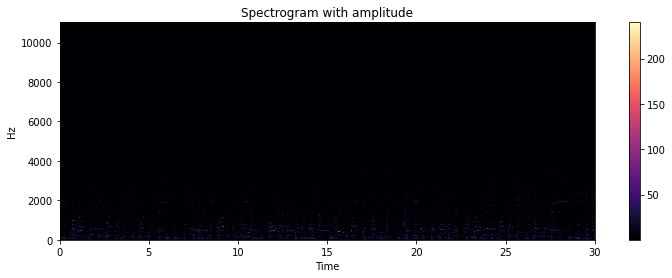

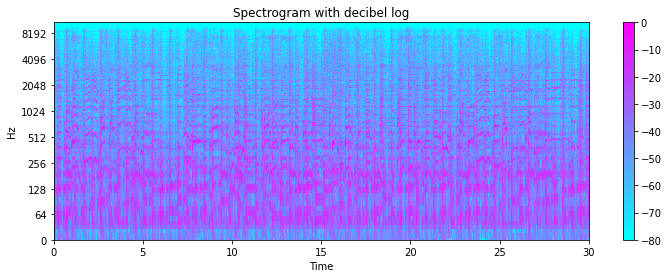

In [13]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()


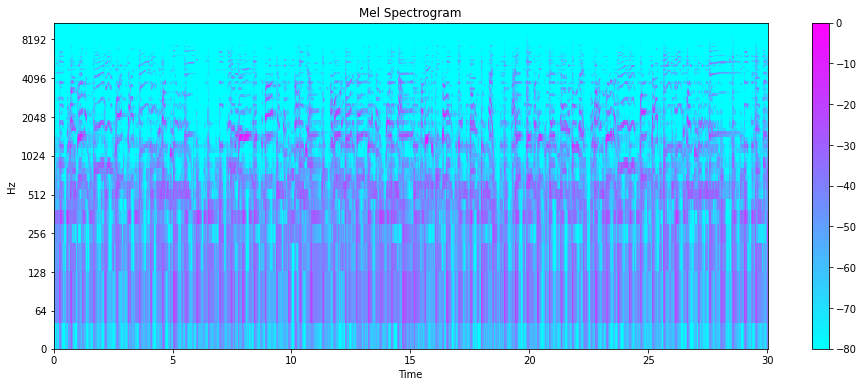

In [14]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

### Music Genre Classification using K Nearest Neighbours

In [28]:
# Function to perform actual distance calculations between features
def distance(instance1, instance2, k):
    distance = 0
    en1 = instance1[0]
    cn1 = instance1[1]
    en2 = instance2[0]
    cn2 = instance2[1]
    distance += np.trace(np.dot(np.linalg.inv(cn2). cn1))
    distance += np.log(np.linalg.det(cn2) - np.log(np.linalg.det(cn1)))
    distance -= k
    return distance

In [29]:
#  Function to get the distance feature vectors and find neighbours
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range(len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))

    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    
    return neighbors

In [30]:
# Identify the class of those neighbours 
def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)

    return sorter[0][0]

In [31]:
# Function to evaluate the model
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    
    return (1.0 * correct) / len(testSet)

In [32]:
# Directory for keeping the Dataset
Directory = "./Dataset/Data/genres_original/"

In [35]:
# Binary File where we will collect all the features extracted using mfcc Mel Frequency Cepstral Co-efficients
f = open("my.dat", 'wb')

i = 0

for folder in os.listdir(Directory):
    i += 1
    if i == 11:
        break
    for file in os.listdir(Directory+folder):        
        try:
            (rate, sig) = wav.read(Directory+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print('Got an exception: ', e, ' in folder: ', folder, ' filename: ', file)        

f.close()

In [36]:
# Split the dataset into training and testing sets respectively
dataset = []

def loadDataset(filename, split, trSet, teSet):
    with open('my.dat', 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])
trainingSet = []
testSet = []
loadDataset('my.dat', 0.66, trainingSet, testSet)

In [38]:
def distance(instance1 , instance2 , k ):
    distance =0 
    mm1 = instance1[0] 
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) 
    distance+=(np.dot(np.dot((mm2-mm1).transpose() , np.linalg.inv(cm2)) , mm2-mm1 )) 
    distance+= np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance-= k
    return distance

In [39]:
# making predictions using KNN
leng = len(testSet)
predictions = []
for x in range(leng):
    predictions.append(nearestClass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

0.675


In [51]:
# testing the code with external samples

test_dir = "./Test/"
# test_file = test_dir + "test.wav"
test_file = test_dir + "test2.wav"
# test_file = test_dir + "test4.wav"

In [52]:
(rate, sig) = wav.read(test_file)
mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
covariance = np.cov(np.matrix.transpose(mfcc_feat))
mean_matrix = mfcc_feat.mean(0)
feature = (mean_matrix, covariance, i)

In [53]:
from collections import defaultdict
results = defaultdict(int)

directory = "./Dataset/Data/genres_original/"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [54]:
pred = nearestClass(getNeighbors(dataset, feature, 5))
print(results[pred])

jazz
